# 0. Load parameters


The value in the first cell is substituted with the value of the parameter inserted by creating a notebook from the template.


In [1]:
# | tags: [parameters]
subject = "103"

In [1]:
# | tags: [parameters]
# Injected Parameters
subject = 105

In [2]:
from eeglabio.utils import export_mne_raw
import autoreject

from pathlib import Path
import toml
from spectral.utils import print_date_time, read_parameters, config_project
from spectral.specparam import specparam2pandas
from spectral.viz import plot_epochs
import mne

import pandas as pd

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
epochs_preproc_path = my_paths["epochs_preproc_path"]
figures_path = my_paths["figures_path"]

# create additional paths
specparam_path = my_paths["specparam_path"]
epochs_eeglab = my_paths["epochs_eeglab"]
Path(specparam_path).mkdir(parents=True, exist_ok=True)
Path(epochs_eeglab).mkdir(parents=True, exist_ok=True)

print_date_time()


mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

2024-04-25 23:21:52
Using matplotlib as 2D backend.


This file contains preprocessing files after downsampling them.


# 2. Work with epochs


In [5]:
epochs = mne.read_epochs(
    f"{project_path}/analysis/sub-{subject}_good_epochs-epo.fif", preload=True
)
epochs.info
print( f"Bad channels are {epochs.info['bads']}")

Reading /Users/daniel/PhD/Projects/psd-path/analysis/sub-105_good_epochs-epo.fif ...


    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
bad channels are ['E233', 'E255', 'E218', 'E144', 'E232', 'E132', 'E81', 'E227', 'E9', 'E237']


In [7]:
auto_reject_pre_ica = autoreject.AutoReject(
    n_interpolate=[1, 2, 4, 8, 32, 64, 128],
    n_jobs=-1,
    random_state=100,
    thresh_method="bayesian_optimization",
    verbose=False,
    # n_interpolate=np.array([0]),
    # consensus=0.8,
).fit(epochs[:20])
print("fitting finished")
epochs_ar, reject_log = auto_reject_pre_ica.transform(epochs, return_log=True)


# depending of the resampling - different number of epochs are rejected

reject_plot = reject_log.plot("vertical")

Setting channel interpolation method to {'eeg': 'spline'}.


Interpolating bad channels.


    Automatic origin fit: head of radius 95.5 mm


Computing interpolation matrix from 246 sensor positions


Interpolating 10 sensors


No projector specified for this dataset. Please consider the method self.add_proj.


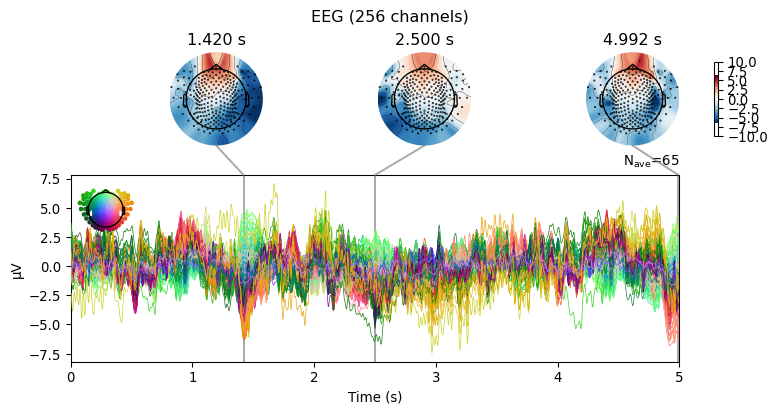

Effective window size : 5.004 (s)


Plotting power spectral density (dB=True).


Averaging across epochs...


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:55: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  ).plot(average=False, picks="eeg", exclude="bads", show=False)


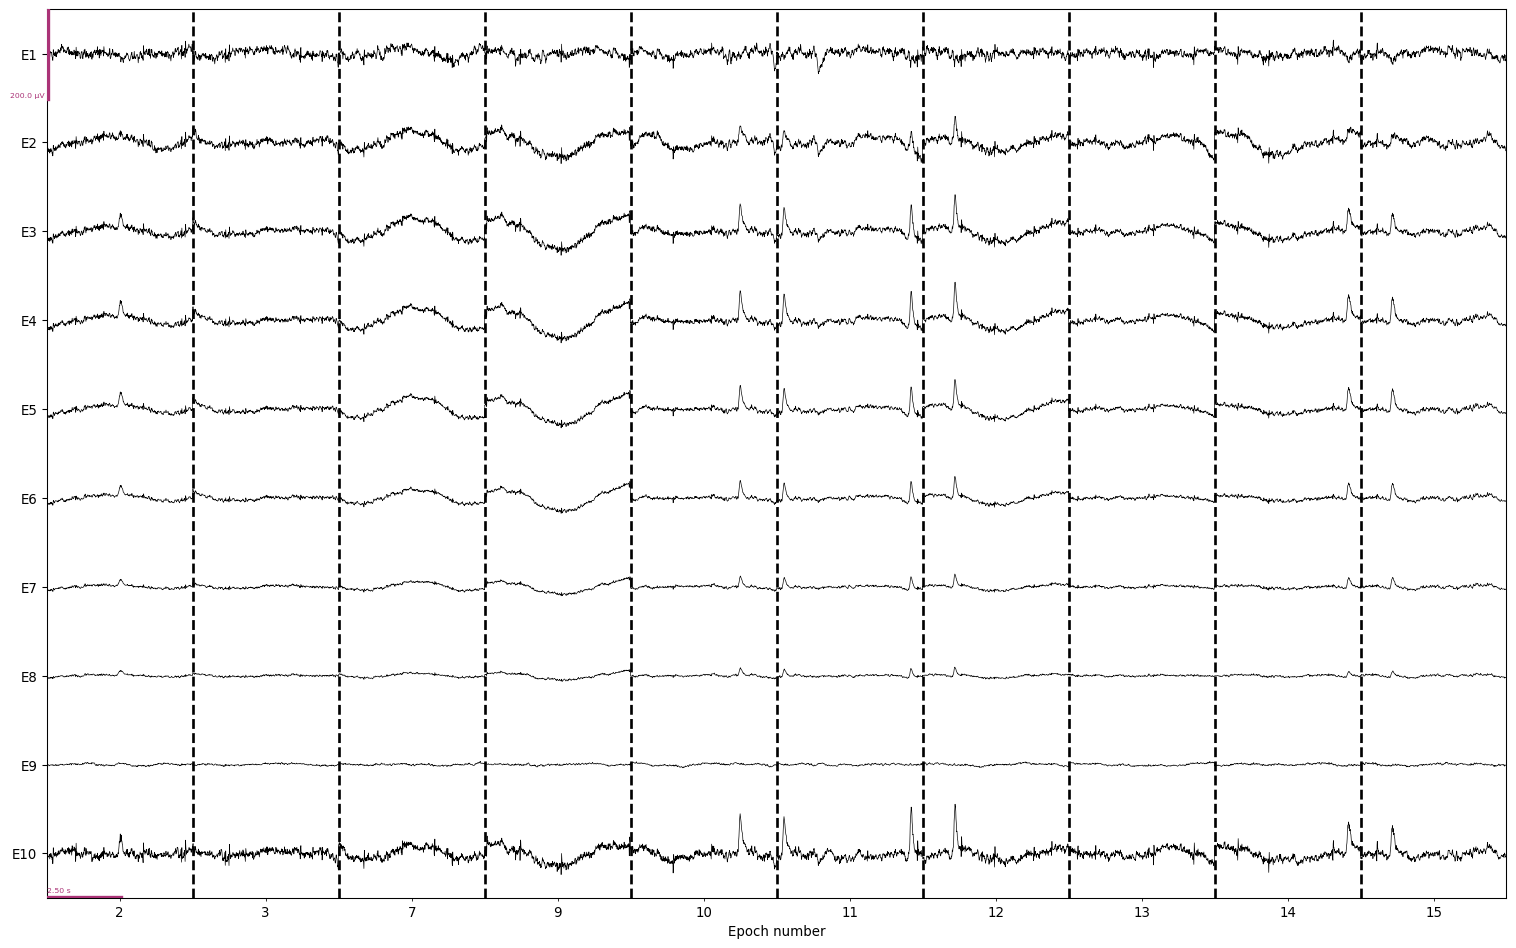

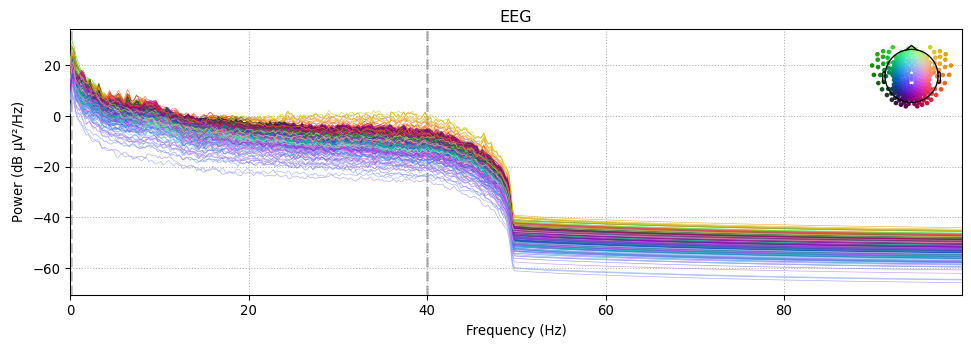

In [6]:
epochs_interpolated = epochs_ar.copy().interpolate_bads(exclude=["VREF"])
plot_epochs(
    epochs_interpolated, figures_path, subject, stage="final_interpolared_epochs"
)

# Save to eeglab


In [7]:
from eeglabio.utils import export_mne_epochs

try:
    export_mne_epochs(
        epochs_interpolated,
        f"{epochs_eeglab}/sub-{subject}_clean_epochs_ica-manual_interpolared-epo.set",
    )
except Exception as e:
    print(e)

/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/eeglabio/utils.py:169: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  export_set(fname, inst.get_data(), inst.info['sfreq'], inst.events,
/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/eeglabio/epochs.py:143 EEGLABIO: WARNING: Events doesn't meet the requirement of at least one event per epoch, adding dummy events


In [8]:
from specparam.plts.spectra import plot_spectra
from specparam import SpectralGroupModel


fg = SpectralGroupModel(
    peak_width_limits=[1, 6],
    min_peak_height=0.15,
    peak_threshold=2.0,
    max_n_peaks=6,
    verbose=False,
)

# Specparam for non augmented data:


In [1]:
psd = epochs.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings

# Define the frequency range to fit
freq_range = [2, 40]
fg.fit(freqs, spectra, freq_range)
fg.plot()

NameError: name 'epochs' is not defined

# Specparam for augmented data


    Using multitaper spectrum estimation with 7 DPSS windows


Subject 105 done


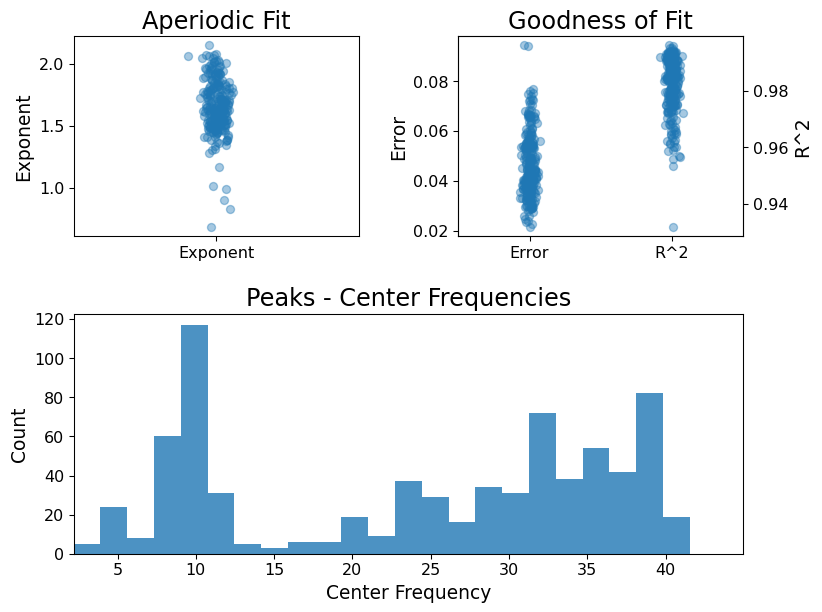

In [10]:
psd = epochs_ar.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings

# Define the frequency range to fit
freq_range = [2, 40]
fg.fit(freqs, spectra, freq_range)
fg.plot()

df = specparam2pandas(fg)
df.to_csv(f"{specparam_path}/sub-{subject}-specparam.csv", index=False)
print(f"Subject {subject} done")